In [1]:
import numpy as np
import math
from scipy import sparse
import matplotlib.pyplot as plt

class UniformPeriodicGrid:

    def __init__(self, N, length):
        self.values = np.linspace(0, length, N, endpoint=False)
        self.dx = self.values[1] - self.values[0]
        self.length = length
        self.N = N


class NonUniformPeriodicGrid:

    def __init__(self, values, length):
        self.values = values
        self.length = length
        self.N = len(values)


class DifferenceUniformGrid:

    def __init__(self, derivative_order, convergence_order, grid, stencil_type='centered'):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        #print("Check1")
        #Goal: Return D
        #initial parameters
        N=grid.N
        h=grid.dx
        ddx=derivative_order
        convE=convergence_order

        #print("Check2")
        #Create R matrix
        convE=2*math.ceil(convE/2)
        d=2*math.floor((ddx+convE-1)/2)+1
        mid=math.floor(d/2)

        R=np.zeros((d,d))
        r0=np.ones(d)
        r=h*np.arange(start=-(d-1)/2, stop=(d+1)/2, step=1)

        R[0]=r0
        i=1
        while i<d:
            R[i]=r**i
            i+=1
            
        #print("Check3")
        # Create k vector
        k=np.zeros(d)
        k[ddx]=1

        #Solve for coefficients, a
        a=math.factorial(ddx)*np.linalg.inv(R)@k
        
        #print("Check4")
        #Arrange coefficients in a sparse, derivative matrix: D
        lowerTri=np.arange(start=-N+1, stop=-N+mid+1, step=1)
        upperTri=np.arange(start=N-mid, stop=N, step=1)
        mainDiag=np.arange(start=-mid, stop=mid+1, step=1)

        #print("Main Diag: ", mainDiag)
        #print("a: ", a)
        Dmd = sparse.diags(a, mainDiag, shape=(N, N))
        DuT = sparse.diags(a[:mid], upperTri, shape=(N, N))
        DlT = sparse.diags(a[mid+1:], lowerTri, shape=(N, N))
        D = Dmd + DuT + DlT
        #plot_2D(D.A)
        self.matrix = D
        pass

    def __matmul__(self, other):
        return self.matrix @ other


class DifferenceNonUniformGrid:

    def __init__(self, derivative_order, convergence_order, Grid, stencil_type='centered'):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        self.grid = Grid
        
        grid=Grid.values
        length=Grid.length
        N=Grid.N
        ddx=derivative_order
        convE=convergence_order
        
        #Create R matrix
        convE=2*math.ceil(convE/2)
        d=2*math.floor((ddx+convE-1)/2)+1
        mid=math.floor(d/2)

        # Create k vector
        k=np.zeros(d)
        k[ddx]=math.factorial(ddx)

        #Begin iteration to construct D by individual stencil
        D = sparse.csr_matrix(np.zeros((N,N)))
        i=0
        while i<N: 
            R=np.zeros((d,d))
            r0=np.ones(d)
            r=np.roll(grid, mid-i)[0:d]-grid[i]*np.ones(d)
            if i<mid:
                j=0
                while j<mid-i:
                    r[j]=r[j]-length
                    j+=1
            elif i>N-mid-1:
                j=-1 
                while j>(N-i)-mid-2:
                    r[j]=r[j]+length
                    j-=1        

            R[0]=r0
            j=1
            while j<d:
                R[j]=r**j
                j+=1
        
            Rinv=np.linalg.inv(R)

            #Solve for coefficients, a
            a=Rinv@k

            #Construct D row i, col j
            a_0s=np.concatenate((a,np.zeros(N-d)))
            a_0s_rolled=np.roll(a_0s, i-mid)
            D[i]=a_0s_rolled

            i+=1
        self.matrix = D
        pass

    def __matmul__(self, other):
        return self.matrix @ other
    
def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

<class 'numpy.ndarray'>


C:\Users\Owner\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\Owner\AppData\Local\Temp/ipykernel_19076/4188042229.py:152: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


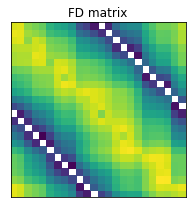

In [14]:
InputValues=np.array([0, 0.005, 0.02, 0.034,0.04,0.058,0.076,0.083,0.09, 0.12, 0.13, 0.1415, 0.15, 0.159, 0.177, 0.184, 0.19, 0.20, 0.23, 0.239, 0.247, 0.25, 0.28, 0.29])
A=NonUniformPeriodicGrid(InputValues, 0.3)
print(type(A.values))
d=DifferenceNonUniformGrid(1, 22, A, stencil_type='centered')
d.matrix
plot_2D(d.matrix.A)

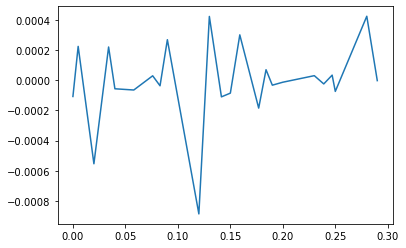

In [16]:
x=d.grid.values
length=d.grid.length
tight=np.linspace(0,(100-1)/100*length,100)
f = 1/(2+np.sin(2*np.pi*x/length)**2)
f_tight = 1/(2+np.sin(2*np.pi*tight/length)**2)

df = d.matrix @ f
df0 = -(2*np.pi/length)*((2*np.cos(2*np.pi*x/length)*np.sin(2*np.pi*x/length))/(2 + np.sin(2*np.pi*x/length)**2)**2)
df0_tight = -(2*np.pi/length)*((2*np.cos(2*np.pi*tight/length)*np.sin(2*np.pi*tight/length))/(2 + np.sin(2*np.pi*tight/length)**2)**2)

fig, ax = plt.subplots()


#ax.plot(tight,f_tight)
#ax.plot(x,f)

#ax.plot(x,df0)
#ax.plot(tight,df0_tight)
ax.plot(x,df-df0)
plt.show()

[0.    0.005 0.02  0.034 0.04  0.058 0.076 0.083 0.09  0.12  0.13  0.15
 0.19  0.2   0.23  0.25 ]
d= 5
mid= 2
k= [0. 0. 0. 6. 0.]
a_ 0 = [   15873.01587302   -70129.87012987  1628571.42857145 -1939393.93939396
   365079.36507937]
a_ 1 = [ -14471.24304267 -388235.29411765  802507.83699059 -632653.06122449
  232851.76139421]
a_ 2 = [ -838235.29411765  1103448.27586207    71428.57142857 -1086641.55317299
   750000.        ]
a_ 3 = [ -118970.16451343    37593.98496241  1334154.35139573 -1507936.50793651
   255158.3360918 ]
a_ 4 = [ -483351.23523093  2409297.05215419 -2160493.82716049   203053.93112411
    31494.07911313]
a_ 5 = [-506154.84288954  681883.43382142  -30864.19753086 -535399.34492316
  390534.95152214]
a_ 6 = [  -12919.89664083  -347222.22222222  3117913.83219954 -4556241.1010916
  1798469.3877551 ]
a_ 7 = [ -248655.91397849  1468769.32591218 -1588527.30281301   318877.55102041
    49536.33985892]
a_ 8 = [-1623376.62337662  3943152.87932309 -2500000.           233415.23341523
 

C:\Users\Owner\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\Owner\AppData\Local\Temp/ipykernel_8740/777014033.py:99: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


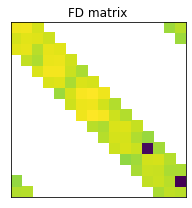

In [136]:
#Modify Class Cell

#Differences                0.4, 0.5, 0.3, 0.1, 0.2, 0.4, 0.1, 0.3, 0.2, 0.5
NonUniform_Values=np.array([0, 0.005, 0.02, 0.034,0.04,0.058,0.076,0.083,0.09, 0.12, 0.13, 0.15, 0.19, 0.20, 0.23, 0.25]) #ends at 0.3
#NonUniform_Values=np.linspace(0,9/10,10)[:]
NonUniform_Length=0.3
NU_grid=NonUniformPeriodicGrid(NonUniform_Values,NonUniform_Length)

#     DifferenceNonUniformGrid(derivative_order, convergence_order, grid, stencil_type='centered')
#NU_d= DifferenceNonUniformGrid(1,                2,               NU_grid, stencil_type='centered')
ddx=3
convE=2
grid=NU_grid.values
length=NU_grid.length

#Goal: Return D
#initial parameters
N=NU_grid.N
#ddx=derivative_order
#convE=convergence_order

#Create R matrix
convE=2*math.ceil(convE/2)
d=2*math.floor((ddx+convE-1)/2)+1
mid=math.floor(d/2)

# Create k vector
k=np.zeros(d)
k[ddx]=math.factorial(ddx)

#Begin iteration to construct D by individual stencil
D = sparse.csr_matrix(np.zeros((N,N)))
i=0
while i<N: 
    R=np.zeros((d,d))
    r0=np.ones(d)
    r=np.roll(grid, mid-i)[0:d]-grid[i]*np.ones(d)
    if i<mid:
        j=0
        while j<mid-i:
            r[j]=r[j]-length
            j+=1
    elif i>N-mid-1:
        j=-1 
        while j>(N-i)-mid-2:
            r[j]=r[j]+length
            j-=1        

    R[0]=r0
    j=1
    while j<d:
        R[j]=r**j
        j+=1
        
    Rinv=np.linalg.inv(R)
    #print("R^(-1)_",i,"=",R)

    #Solve for coefficients, a
    a=Rinv@k

    #Construct D row i, col j
    a_0s=np.concatenate((a,np.zeros(N-d)))
    a_0s_rolled=np.roll(a_0s, i-mid)
    D[i]=a_0s_rolled

    i+=1

True


C:\Users\Owner\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


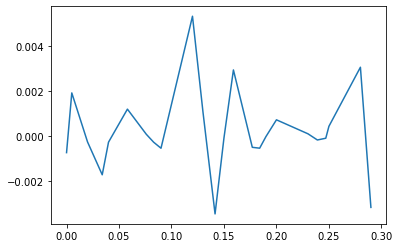

In [49]:
#Testing Cell

import numpy as np
import math

TestID=3
InputValues=np.array([0, 0.005, 0.02, 0.034,0.04,0.058,0.076,0.083,0.09, 0.12, 0.13, 0.1415, 0.15, 0.159, 0.177, 0.184, 0.19, 0.20, 0.23, 0.239, 0.247, 0.25, 0.28, 0.29])
order_range = [2, 4, 6, 8]
order_index = np.arange(4)
error_bound_3 = [0.5, 0.05, 0.013, 0.006]

order = order_range[order_index[TestID]]
grid = NonUniformPeriodicGrid(InputValues, 0.3)
x = grid.values
#print("order: ", order)
#print("grid.values: ", grid.values)
#print("grid.N: ", grid.N)
#print("grid.dx: ", grid.dx) 
d = DifferenceNonUniformGrid(1, order, grid)
length=d.grid.length
f = 1/(2+np.sin(2*np.pi*x/length)**2)
#print("derivative_order: ", d.derivative_order)
#print("convergence_order: ", d.convergence_order)
#print("stencil_type: ", d.stencil_type) 
#plot_2D(d.matrix.A)
df = d.matrix @ f
df0 = -(2*np.pi/length)*((2*np.cos(2*np.pi*x/length)*np.sin(2*np.pi*x/length))/(2 + np.sin(2*np.pi*x/length)**2)**2)

error = np.max(np.abs(df - df0))
error_est = error_bound_3[order_index[TestID]]
print(error<error_est)
fig, ax = plt.subplots()
ax.plot(x, df-df0)
plt.show()


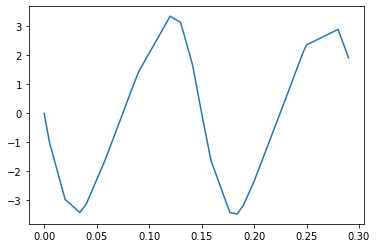